<a href="https://colab.research.google.com/github/apschlissel/w266-final-project/blob/main/BERT_reddit_%2B_NB%2C_n_%3D_100_(Kevin).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
!pip install -q transformers

In [41]:
!pip install simpletransformers

In [42]:
# Useful Links / Source Code
# Source: https://towardsdatascience.com/multi-class-text-classification-with-deep-learning-using-bert-b59ca2f5c613
# Source: https://github.com/susanli2016/NLP-with-Python/blob/master/Text_Classification_With_BERT.ipynb
# Source: https://towardsdatascience.com/how-to-use-the-reddit-api-in-python-5e05ddfd1e5c
# Source: https://medium.com/@senthilnathangautham/colab-gcp-compute-how-to-link-them-together-98747e8d940e
# Source: https://stackoverflow.com/questions/49031798/when-i-use-google-colaboratory-how-to-save-image-weights-in-my-google-drive

In [43]:
from __future__ import print_function
import ipywidgets as widgets
from transformers import pipeline
from simpletransformers.t5 import T5Model, T5Args
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import logging
import numpy as np
import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification
import json
import random
import math
import requests
from bs4 import BeautifulSoup

In [44]:
# note that CLIENT_ID refers to 'personal use script' and SECRET_TOKEN to 'token'
auth = requests.auth.HTTPBasicAuth('pigKA_TKnDkXcatEGcbo8g', 'nawGKK2MfPtC6vKz8TjaNEnmYfAggA')

# here we pass our login method (password), username, and password
data = {'grant_type': 'password',
        'username': 'Katsuuu100',
        'password': 'Testing159753'}

# setup our header info, which gives reddit a brief description of our app
headers = {'User-Agent': 'MyBot/0.0.1'}

# send our request for an OAuth token
res = requests.post('https://www.reddit.com/api/v1/access_token',
                    auth=auth, data=data, headers=headers)

# convert response to JSON and pull access_token value
TOKEN = res.json()['access_token']

# add authorization to our headers dictionary
headers = {**headers, **{'Authorization': f"bearer {TOKEN}"}}

# while the token is valid (~2 hours) we just add headers=headers to our requests
requests.get('https://oauth.reddit.com/api/v1/me', headers=headers)

<Response [200]>

In [45]:
# HTML web scraper, scrape top subreddits, SFW only.
# 
# Source: https://realpython.com/beautiful-soup-web-scraper-python/
# Source: https://stackoverflow.com/questions/40210093/how-do-i-scrape-only-div-class-quotetext-from-a-website-using-python


URL = "http://redditlist.com/sfw/"
page = requests.get(URL)

soup = BeautifulSoup(page.content, "html.parser")
# print(soup.prettify())
job_elements = soup.find_all("div", class_="listing-item")

# print(job_elements[0])

# Filter to only the Top 125 Most subscribed subreddits
job_elements = job_elements[125:250]

master_subreddit_list = []
# Find subreddit names
for job_element in job_elements:
  links = job_element.find_all("a")
  for link in links:
    print(link.text.strip())
    master_subreddit_list.append(link.text.strip())

announcements
funny
AskReddit
gaming
aww
Music
pics
worldnews
movies
science
todayilearned
videos
news
Showerthoughts
Jokes
food
askscience
IAmA
EarthPorn
gifs
nottheonion
books
DIY
explainlikeimfive
Art
LifeProTips
space
sports
mildlyinteresting
Documentaries
gadgets
memes
tifu
photoshopbattles
UpliftingNews
GetMotivated
dataisbeautiful
listentothis
history
philosophy
television
InternetIsBeautiful
Futurology
WritingPrompts
OldSchoolCool
personalfinance
nosleep
creepy
TwoXChromosomes
wallstreetbets
technology
wholesomememes
AdviceAnimals
interestingasfuck
Fitness
politics
WTF
lifehacks
oddlysatisfying
relationship_advice
Minecraft
NatureIsFuckingLit
travel
facepalm
Whatcouldgowrong
nextfuckinglevel
pcmasterrace
leagueoflegends
BlackPeopleTwitter
me_irl
Unexpected
dankmemes
bestof
dadjokes
buildapc
Tinder
PS4
MadeMeSmile
AnimalsBeingBros
Damnthatsinteresting
tattoos
CryptoCurrency
AnimalsBeingJerks
photography
nba
AnimalsBeingDerps
gardening
BikiniBottomTwitter
trippinthroughtime
Watch

In [46]:
# Pick 5 random subreddits
five_random_subreddits = random.choices(master_subreddit_list, k=5)
print(five_random_subreddits)

['instant_regret', 'movies', 'xboxone', 'AnimalsBeingBros', 'Damnthatsinteresting']


In [82]:
# Source: https://towardsdatascience.com/how-to-use-the-reddit-api-in-python-5e05ddfd1e5c
# Source: https://pynative.com/python-random-choice/
# Pull from 5 classes. 5 classes = 5 subreddits.

my_list_of_dictionaries = []
total = 0
# Target Count for test set = 100.
test_set_count = 20
n = int(math.ceil(test_set_count/0.20/25))

# url_list_check = [f"https://oauth.reddit.com/r/{five_random_subreddits[0]}/new/",
#           f"https://oauth.reddit.com/r/{five_random_subreddits[1]}/new/",
#           f"https://oauth.reddit.com/r/{five_random_subreddits[2]}/new/",
#           f"https://oauth.reddit.com/r/{five_random_subreddits[3]}/new/",
#           f"https://oauth.reddit.com/r/{five_random_subreddits[4]}/new/"
#           ]

url_list_check = [f"https://oauth.reddit.com/r/wallstreetbets/new/",
          f"https://oauth.reddit.com/r/teenagers/new/",
          f"https://oauth.reddit.com/r/copypasta/new/",
          f"https://oauth.reddit.com/r/genz/new/",
          f"https://oauth.reddit.com/r/unpopularopinion/new/",
          # f"https://oauth.reddit.com/r/frat/new/"
          ]

for i in range(len(url_list_check)):
    
  # print(url_list_check[i])
  res_check = requests.get(url_list_check[i],
                    headers=headers,
                    params={"limit": "1"})
  
  # print(res_check)
  # print(json.dumps(res_check.json()["data"]["children"][0]["data"]["name"], indent=4))
  name = res_check.json()["data"]["children"][0]["data"]["name"]
  page_count = 25
  
  for j in range(n):

    # url_list = [f"https://oauth.reddit.com/r/{five_random_subreddits[0]}/new/?count={page_count}&after={name}",
    #         f"https://oauth.reddit.com/r/{five_random_subreddits[1]}/new/?count={page_count}&after={name}",
    #         f"https://oauth.reddit.com/r/{five_random_subreddits[2]}/new/?count={page_count}&after={name}",
    #         f"https://oauth.reddit.com/r/{five_random_subreddits[3]}/new/?count={page_count}&after={name}",
    #         f"https://oauth.reddit.com/r/{five_random_subreddits[4]}/new/?count={page_count}&after={name}"
    #         ]

    url_list = [f"https://oauth.reddit.com/r/wallstreetbets/new/?count={page_count}&after={name}",
            f"https://oauth.reddit.com/r/teenagers/new/?count={page_count}&after={name}",
            f"https://oauth.reddit.com/r/copypasta/new/?count={page_count}&after={name}",
            f"https://oauth.reddit.com/r/genz/new/?count={page_count}&after={name}",
            f"https://oauth.reddit.com/r/unpopularopinion/new/?count={page_count}&after={name}",
            # f"https://oauth.reddit.com/r/frat/new/?count={page_count}&after={name}"
            ]
    
    print("Page Count:", page_count)
    print("Name:", name)
    print("Url:", url_list[i])
    
    res = requests.get(url_list[i],
                    headers=headers)
                    # params={"limit": "100"})

    reddit_dictionary = res.json()

    for k in range(len(reddit_dictionary["data"]["children"])):
      my_dictionary = {}
      my_dictionary["subreddit"] = reddit_dictionary["data"]["children"][k]["data"]["subreddit"]
      my_dictionary["text"] = reddit_dictionary["data"]["children"][k]["data"]["selftext"]
      # If a reddit post is has no body text:
      if my_dictionary["text"] == "":
        # Replace with title of reddit post.
        my_dictionary["text"] = reddit_dictionary["data"]["children"][k]["data"]["title"]
      
      print(my_dictionary["text"])
      # my_dictionary["title"] = reddit_dictionary["data"]["children"][k]["data"]["title"]
      # my_dictionary["url"] = reddit_dictionary["data"]["children"][k]["data"]["url"]
      # print(reddit_dictionary["data"]["children"][k]["data"]["subreddit"])
      # print(reddit_dictionary["data"]["children"][k]["data"]["selftext"])
      # print(reddit_dictionary["data"]["children"][k]["data"]["url"])
      my_list_of_dictionaries.append(my_dictionary)
      total += 1
      name = reddit_dictionary["data"]["children"][k]["data"]["name"]
    # print(json.dumps(my_list_of_dictionaries, indent=4, sort_keys=False))
    
    page_count += 25

print("Total gathered:", total)

Page Count: 25
Name: t3_tqr0yi
Url: https://oauth.reddit.com/r/wallstreetbets/new/?count=25&after=t3_tqr0yi
 I thought about shorting OKTA overnight. 

And I stop myself from shorting this morning. 

I am the dumb money. 

Wanting to Short? —&gt; Went long. (Inverse one's trade as learned from WSB preaching.)

Went Long via shares and shorting April 1 $140 put. 

Added shares...

Now:

1000 shares at around $142\`

\-1 April 1, 2022 $140 Put

\- 1 April 1, 2022 $142 Call

Proof:

[https://imgur.com/gallery/DOILHOv](https://imgur.com/gallery/DOILHOv)

OKTA closed around $149.

&amp;#x200B;

Thank you, ladies and gentlemen of WSB!

&amp;#x200B;

Will ride these shares.

The OKTA hack was not as terrible as the solar wind hack, maybe?
What I think when I see your gain porn
GME - Simplest DD - Beginning of 🌙
GME $2500 to 14,500 in 8 trading days. Roll the options over and keep the train rolling.
A Race to Supply NatGas to Germany (Eurobeat Mix)
Should I have sold these? I had 30 more, it’s

In [83]:
# Source: https://github.com/susanli2016/NLP-with-Python/blob/master/Text_Classification_With_BERT.ipynb
# Convert list of dictionaries into pandas df
df = pd.DataFrame(my_list_of_dictionaries)
df.head()

,subreddit,text
0,wallstreetbets,I thought about shorting OKTA overnight. \n\n...
1,wallstreetbets,What I think when I see your gain porn
2,wallstreetbets,GME - Simplest DD - Beginning of 🌙
3,wallstreetbets,"GME $2500 to 14,500 in 8 trading days. Roll th..."
4,wallstreetbets,A Race to Supply NatGas to Germany (Eurobeat Mix)


In [84]:
# Check if there is body text in reddit post
print(df['text'][0])

 I thought about shorting OKTA overnight. 

And I stop myself from shorting this morning. 

I am the dumb money. 

Wanting to Short? —&gt; Went long. (Inverse one's trade as learned from WSB preaching.)

Went Long via shares and shorting April 1 $140 put. 

Added shares...

Now:

1000 shares at around $142\`

\-1 April 1, 2022 $140 Put

\- 1 April 1, 2022 $142 Call

Proof:

[https://imgur.com/gallery/DOILHOv](https://imgur.com/gallery/DOILHOv)

OKTA closed around $149.

&amp;#x200B;

Thank you, ladies and gentlemen of WSB!

&amp;#x200B;

Will ride these shares.

The OKTA hack was not as terrible as the solar wind hack, maybe?


In [85]:
# Check if total is correct per subreddit
df['subreddit'].value_counts()

wallstreetbets      100
teenagers           100
copypasta           100
GenZ                100
unpopularopinion    100
Name: subreddit, dtype: int64

In [86]:
possible_labels = df.subreddit.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'GenZ': 3,
 'copypasta': 2,
 'teenagers': 1,
 'unpopularopinion': 4,
 'wallstreetbets': 0}

In [87]:
df['label'] = df.subreddit.replace(label_dict)

In [88]:
df.head()

,subreddit,text,label
0,wallstreetbets,I thought about shorting OKTA overnight. \n\n...,0
1,wallstreetbets,What I think when I see your gain porn,0
2,wallstreetbets,GME - Simplest DD - Beginning of 🌙,0
3,wallstreetbets,"GME $2500 to 14,500 in 8 trading days. Roll th...",0
4,wallstreetbets,A Race to Supply NatGas to Germany (Eurobeat Mix),0


In [89]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.20, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

In [90]:
df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [91]:
df.groupby(['subreddit', 'label', 'data_type']).count()

text
subreddit        label data_type      
GenZ             3     train        80
                       val          20
copypasta        2     train        80
                       val          20
teenagers        1     train        80
                       val          20
unpopularopinion 4     train        80
                       val          20
wallstreetbets   0     train        80
                       val          20

In [92]:
# Bert model begins
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

In [93]:
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2277: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [94]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [95]:
len(dataset_train), len(dataset_val)

(400, 100)

In [96]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [97]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [98]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [99]:
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

In [100]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [101]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [102]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [103]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [104]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [105]:
f1_list = []
train_loss_list = []
val_loss_list = []

for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'/content/gdrive/MyDrive/W266/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    train_loss_list.append(loss_train_avg)
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    val_loss_list.append(val_loss)
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    f1_list.append(val_f1)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/134 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.4950008040933467
Validation loss: 1.315081634942223
F1 Score (Weighted): 0.405191732162819


Epoch 2:   0%|          | 0/134 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.1647498069414453
Validation loss: 1.1249980786267448
F1 Score (Weighted): 0.5814979674105251


Epoch 3:   0%|          | 0/134 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.8694271992391615
Validation loss: 1.0251208482419742
F1 Score (Weighted): 0.6284142543186185


Epoch 4:   0%|          | 0/134 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.6687523751561322
Validation loss: 0.9793986897258198
F1 Score (Weighted): 0.6241753774680603


Epoch 5:   0%|          | 0/134 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.5619270430127187
Validation loss: 0.9736643477397806
F1 Score (Weighted): 0.6381592155245019


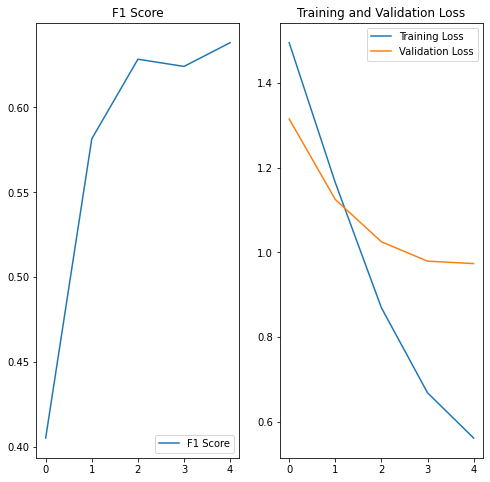

In [106]:
# Plot F1 and losses over epochs
acc = f1_list
#val_acc = model.history['val_accuracy']

loss = train_loss_list
val_loss = val_loss_list

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='F1 Score')
#plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('F1 Score')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [107]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [108]:
model.load_state_dict(torch.load('/content/gdrive/MyDrive/W266/finetuned_BERT_epoch_1.model', map_location=torch.device('cpu')))

<All keys matched successfully>

In [109]:
_, predictions, true_vals = evaluate(dataloader_validation)

In [110]:
accuracy_per_class(predictions, true_vals)

Class: wallstreetbets
Accuracy: 15/20

Class: teenagers
Accuracy: 1/20

Class: copypasta
Accuracy: 18/20

Class: GenZ
Accuracy: 1/20

Class: unpopularopinion
Accuracy: 14/20



In [111]:
# from sklearn.metrics import confusion_matrix,accuracy_score
# cm_bert = confusion_matrix(true_vals, predictions)
# ac_bert = accuracy_score(true_vals, predictions)

In [112]:
# Naive Bayes Model
# Source: https://www.analyticsvidhya.com/blog/2021/01/a-guide-to-the-naive-bayes-algorithm/
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
# X_train, X_val, y_train, y_val
print(X_train.shape)
print(X_val.shape)
# Reshape makes it (2400, 1) instead of (2400, )
# Source: https://stackoverflow.com/questions/58498187/sklearn-transform-error-expected-2d-array-got-1d-array-instead
X_train2 = sc.fit_transform(X_train.reshape(-1,1))
X_test2 = sc.transform(X_val.reshape(-1,1))

(400,)
(100,)


In [117]:
# Source: https://www.analyticsvidhya.com/blog/2021/01/a-guide-to-the-naive-bayes-algorithm/
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train.reshape(-1,1), y_train)

GaussianNB()

In [118]:
y_pred = classifier.predict(X_test2)

0.2


[Text(0, 0.5, 'wallstreetbets'),
 Text(0, 1.5, 'teenagers'),
 Text(0, 2.5, 'copypasta'),
 Text(0, 3.5, 'GenZ'),
 Text(0, 4.5, 'unpopularopinion')]

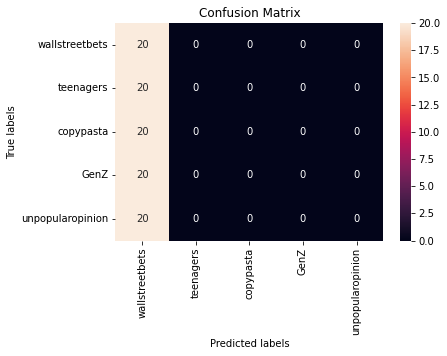

In [119]:
from sklearn.metrics import confusion_matrix,accuracy_score
cm_nb = confusion_matrix(y_val, y_pred)
ac_nb = accuracy_score(y_val, y_pred)
print(ac_nb)

# Source: https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
ax= plt.subplot()
sns.heatmap(cm_nb, annot=True, fmt='g', ax=ax) #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
# Source: https://stackoverflow.com/questions/10998621/rotate-axis-text-in-python-matplotlib
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
ax.xaxis.set_ticklabels(pd.unique(df['subreddit'].values))
ax.yaxis.set_ticklabels(pd.unique(df['subreddit'].values))